### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
#folder =  "Eff_area_PKSflare_crab_cutoff"# c['folder']
folder =   c['folder']
nbidx = 2
print(sys)
print(folder)

Combined100
Combined100_PKSflare_crab_cutoff


In [4]:
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{c['livetime']}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/Dataset/datasets/dataset-simulated-2.154434690031884-hr.fits.gz


## Datasets

In [5]:
e_reco_n_ =1000
if  "Eff_area" in sys:
    e_reco_n_ = 30
    
if  "Combined" in sys:
    e_reco_n_ = 1000


In [6]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if  "Eff_area" in sys:
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        
    if sys == "E_reco":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
        dataset_asimov_N.irf_model.parameters['norm'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
       
    if  "Combined" in sys:
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
       
    if sys == "BKG":
        
        # piece wise model
        # remove old bkg model
        setup.set_up_bkg_sys_V( breake = 10,
                            index1 = 2,
                            index2 = 1.5, 
                            magnitude = magnitude )
        
        dataset_asimov, dataset_asimov_N = setup.run()
        
        setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
        setup.set_piecewise_bkg_model(dataset_asimov_N)
        # energy of the following parameters smaller than ethrshold
        dataset_asimov_N.background_model.parameters['norm0'].frozen = True
        dataset_asimov_N.background_model.parameters['norm1'].frozen = True
        dataset_asimov_N.background_model.parameters['norm2'].frozen = True
        dataset_asimov_N.background_model.parameters['norm3'].frozen = True
        setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
        frozen_pos = 1
        if frozen_pos:
            dataset_asimov.models.parameters['lon_0'].frozen = True
            dataset_asimov.models.parameters['lat_0'].frozen = True
            dataset_asimov_N.models.parameters['lon_0'].frozen = True
            dataset_asimov_N.models.parameters['lat_0'].frozen = True

    return dataset_asimov_N, dataset_asimov, setup

In [7]:
%%time

for e_reco_n in [e_reco_n_]:
#for e_reco_n in [30]:
    print(e_reco_n)

    dataset_N, dataset , setup= set_up(dataset_input)
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset.models = Models.read(path)
    fitting_N = 0
    if fitting_N:
        fit_cor = Fit(store_trace=0)
        dataset_N.e_reco_n = e_reco_n
        minuit_opts = {"tol": 0.01, "strategy": 2}
        #fit_cor.backend = "minuit"
        #fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run(dataset_N)
        print(result_cor)
        print(dataset_N.models)
        print("saving")
        path = f'../{folder}/data/0_model_nui_livetime_{livetime}_{e_reco_n}.yml'
    else:
        path = f'../{folder}/data/0_model_nui_livetime_{livetime}_{e_reco_n}.yml'
        print(path)
        dataset_N = Dataset_load.load_dataset_N(dataset_N, path,bkg_sys = False)        
        dataset_N.models.parameters['tilt'].frozen = False 
        print(dataset.models)
        print(dataset_N.models)
        
        
        

1000
../Combined100_PKSflare_crab_cutoff/data/0_model_nui_livetime_2.154434690031884_1000.yml
DatasetModels

Component 0: SkyModel

  Name                      : Crablog
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                      :      2.300  +/-    0.09             
    amplitude                  :   3.85e-11  +/- 2.6e-12 1 / (cm2 s TeV)
    reference  (frozen)        :      1.000      TeV         
    lambda_                    :      0.100  +/-    0.04 1 / TeV     
    alpha      (frozen)        :      1.000                  
    lon_0                      :    329.680  +/-    0.00 deg         
    lat_0                      :    -30.222  +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-bkg
  Datasets names            : ['dataset']
  Spectral model type       : PowerLawNormSpec

## Asymmetic Minos Error

In [8]:
asym = 1
if asym:
    minos_model_N = Models.read(f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml')
    minos_model = Models.read(f'../{folder}/data/0_model_livetime_{livetime}_np.yml')

    #minos_model_N = Models.read(f'../{folder}/data/4_minos_error_{livetime}_nui.yaml')    
    #minos_model = Models.read(f'../{folder}/data/4_minos_error_{livetime}.yaml')

    lambda_fac = 1
    #if "Combined" in sys:
    #    lambda_fac = 0.01
    minos_model_N.parameters['lambda_'].error_n *= lambda_fac
    minos_model_N.parameters['lambda_'].error_p *= lambda_fac

    minos_model.parameters['lambda_'].error_n *= lambda_fac
    minos_model.parameters['lambda_'].error_p *= lambda_fac

    minos_model_N.parameters['amplitude'].value = dataset_N.models.parameters['amplitude'].value
    minos_model_N.parameters['index'].value = dataset_N.models.parameters['index'].value 
    minos_model_N.parameters['lambda_'].value = dataset_N.models.parameters['lambda_'].value 

    minos_model.parameters['amplitude'].value = dataset.models.parameters['amplitude'].value
    minos_model.parameters['index'].value = dataset.models.parameters['index'].value 
    minos_model.parameters['lambda_'].value = dataset.models.parameters['lambda_'].value 

In [9]:
def compute_cov_asym(cov, minos_model):

    err_asym = np.zeros(cov.shape[0])
    for i , p in enumerate(minos_model.parameters):
        if p.error_n is not None:
            err_asym[i] = - p.error_n
            print(p.name,p.error_n)
    from gammapy.modeling import Covariance
    _cov_n = Covariance(data = cov.correlation * np.outer(err_asym, err_asym),
                         parameters = minos_model.parameters)
    
    err_asym = np.zeros(cov.shape[0])
    for i , p in enumerate(minos_model.parameters):
        if p.error_p is not None:
            err_asym[i] = p.error_p
    from gammapy.modeling import Covariance
    _cov_p = Covariance(data = cov.correlation * np.outer(err_asym, err_asym),
                         parameters = minos_model.parameters)
    return _cov_n , _cov_p
if asym:

    _cov_n , _cov_p = compute_cov_asym(dataset.models[0].covariance, minos_model[0])
    minos_model_n = minos_model[0].copy()
    minos_model_n.covariance = _cov_n
    minos_model_p = minos_model[0].copy()
    minos_model_p.covariance = _cov_p

    _cov_n_N , _cov_p_N = compute_cov_asym(dataset_N.models[0].covariance, minos_model_N[0])
    minos_model_N_n = minos_model_N[0].copy()
    minos_model_N_n.covariance = _cov_n_N
    minos_model_N_p = minos_model_N[0].copy()
    minos_model_N_p.covariance = _cov_p_N


index 0.09583988422704826
amplitude 2.431265157161691e-12
lambda_ 0.037055667714613424
index 0.13004841511663923
amplitude 5.406580937696854e-12
lambda_ 0.040954764418932636


In [10]:
for p in ['amplitude', 'index','lambda_']:
    st_ = p + ' '
    for i,d in enumerate([dataset_input, dataset, dataset_N]):
        value = d.models.parameters[p].value
        error = float(d.models.parameters[p].error)
        
        if p == 'amplitude':
            value  = value *1e11
            
            error  = error *1e11
        st_ += f"${np.round(value,3)} "
        if i >0: 
            st_ += f"\pm {error:.3} $ & "
        else:
            st_ += f"$ & "
            
    print(st_)


amplitude $3.85 $ & $3.85 \pm 0.261 $ & $3.849 \pm 0.592 $ & 
index $2.3 $ & $2.3 \pm 0.093 $ & $2.3 \pm 0.117 $ & 
lambda_ $0.1 $ & $0.1 \pm 0.04 $ & $0.1 \pm 0.041 $ & 


## RND Fluxpoints

In [11]:
infos = np.loadtxt(f"../{folder}/data/1_P_draw_info.txt")
N_max = 1000
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
res_rnds = infos[:N_max, 2]
bias_rnds = infos[:N_max, 3]
flux = np.loadtxt(f"../{folder}/data/1_P_draw_flux.txt")[:N_max]
flux2e = np.loadtxt(f"../{folder}/data/1_P_draw_flux2e.txt")[:N_max]
flux_N = np.loadtxt(f"../{folder}/data/1_N_P_draw_flux.txt")[:N_max]
flux_N2e = np.loadtxt(f"../{folder}/data/1_N_P_draw_flux2e.txt")[:N_max]
pars_N = np.loadtxt(f"../{folder}/data/1_N_P_draw_par.txt")[:N_max]
lives = pars_N[:N_max, -1:]
print(len(shift_rnds))

1000


In [12]:
fpd_Ns, fpd_s = [], []
fpd_Ns_sky, fpd_s_sky = [], []


s = 0.
t = 0.
r = 0.
b = 0.
rnds = f"{s:.6}_{t:.6}_{r:.6}_{b:.6}"
try:
    nns = np.loadtxt(f"../{folder}/data/fluxpoints/1P_draw_fluxpoints.txt")
except:
    nns = []
l = c['livetime']
if np.size(nns) == 1:
    nns = [nns]
print(nns)
for nn in nns:
    nn = int(nn)
    try:
        fluxpoints = FluxPoints.read(
            f"../{folder}/data/fluxpoints/1P_fluxpoints_{l}_{rnds}_{nn}.fits"
        )
        fluxpoints_N = FluxPoints.read(
            f"../{folder}/data/fluxpoints/1P_fluxpoints_N_{l}_{rnds}_{nn}.fits"
        )
       
        model_name = f"../{folder}/data/fluxpoints/1P_model_N_{l}_{rnds}_{nn}.yaml"
        fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
        model_name = f"../{folder}/data/fluxpoints/1P_model_{l}_{rnds}_{nn}.yaml"
        fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))
        fpd_Ns.append(fluxpoints_Nds)
        fpd_s.append(fluxpoints_ds)
        
    except:
        pass


[71. 71. 71. 71. 71. 71. 72.]


In [13]:
len(nns)

7

In [14]:
lives = [livetimes]
len(fpd_Ns)

7

In [15]:
from astropy.units import Quantity
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from astropy.visualization import quantity_support

def plot_error_asym(
        model_p,
        model_n,
        energy_bounds,
        ax=None,
        sed_type="dnde",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        from gammapy.estimators.map.core import DEFAULT_UNIT

        if model_p.is_norm_spectral_model:
            sed_type = "norm"

        if isinstance(energy_bounds, (tuple, list, Quantity)):
            energy_min, energy_max = energy_bounds
            energy = MapAxis.from_energy_bounds(
                energy_min,
                energy_max,
                n_points,
            )
        elif isinstance(energy_bounds, MapAxis):
            energy = energy_bounds

        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        if ax.yaxis.units is None:
            ax.yaxis.set_units(DEFAULT_UNIT[sed_type] * energy.unit**energy_power)

        flux, flux_err_n = model_n._get_plot_flux(sed_type=sed_type, energy=energy)
        flux, flux_err_p = model_p._get_plot_flux(sed_type=sed_type, energy=energy)
        y_lo = scale_plot_flux(flux - flux_err_n, energy_power).quantity[:, 0, 0]
        y_hi = scale_plot_flux(flux + flux_err_p, energy_power).quantity[:, 0, 0]

        with quantity_support():
            ax.fill_between(energy.center, y_lo, y_hi, **kwargs)

        model_n._plot_format_ax(ax, energy_power, sed_type)
        return ax

In [16]:
print(minos_model_n.parameters['lambda_'].error)
print(minos_model_n.parameters['lambda_'].error_n)
print(minos_model_n.parameters['lambda_'].error_p)

0.037055667714613424
0.037055667714613424
0.04360386105048346


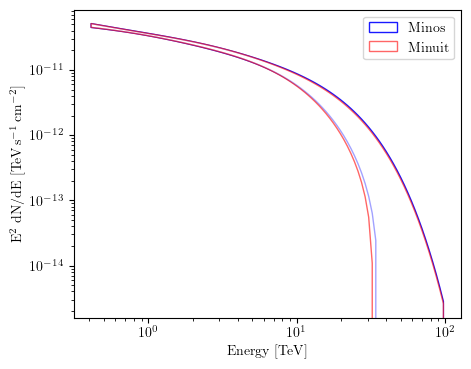

In [17]:
fig,ax = plt.subplots(1, 1, figsize = (5, 4 ))
energy_bounds = (0.4, 100) *u.TeV
energy_power = 2
if asym:

    plot_error_asym(
            model_n=minos_model_n.spectral_model,
            model_p=minos_model_p.spectral_model,
            energy_bounds = energy_bounds,energy_power = energy_power, ax = ax, facecolor= 'white', alpha = 0.9, 
                                                    label = f'Minos',
        edgecolor = 'blue',
        linewidth = 1)
   
    
dataset.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                      facecolor= 'white', alpha = 0.6, edgecolor = 'red',
                                        label = f'Minuit',
                                             linewidth= 1)

ax.legend()


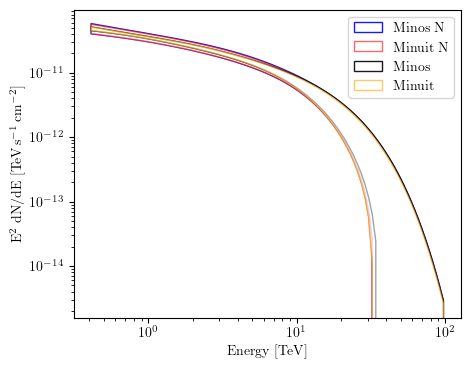

In [18]:
fig,ax = plt.subplots(1, 1, figsize = (5, 4 ))
if asym:

    plot_error_asym(
            model_n=minos_model_N_n.spectral_model,
            model_p=minos_model_N_p.spectral_model,
            energy_bounds = energy_bounds,energy_power = energy_power, ax = ax, facecolor= 'white', alpha = 0.9, 
                                                    label = f'Minos N',
        edgecolor = 'blue',
        linewidth = 1)
   
    
dataset_N.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                      facecolor= 'white', alpha = 0.6, edgecolor = 'red',
                                        label = f'Minuit N',
                                             linewidth= 1)
if asym:

    plot_error_asym(
            model_n=minos_model_n.spectral_model,
            model_p=minos_model_p.spectral_model,
            energy_bounds = energy_bounds,energy_power = energy_power, ax = ax, facecolor= 'white', alpha = 0.9, 
                                                    label = f'Minos',
        edgecolor = 'black',
        linewidth = 1)
   
    
dataset.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                      facecolor= 'white', alpha = 0.6, edgecolor = 'orange',
                                        label = f'Minuit',
                                             linewidth= 1)

ax.legend()
#ax.set_ylim(1e-12, 1e-10)


6 72.0
2.154434690031884
shift 0.95
shift 1.05


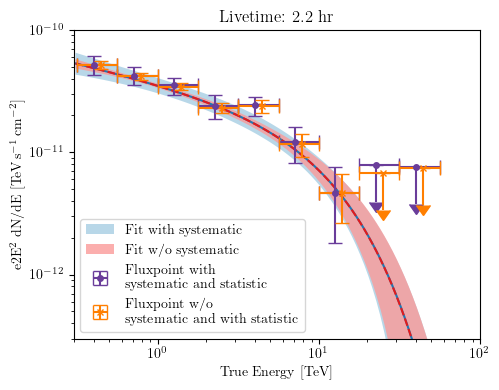

In [19]:
energy_power = 2
alpha = 0.8
energy_bounds = (0.3, 100) *u.TeV
plot_minuit= 0
def plot_spectrum(i, ax):
    live = livetimes[i]
    print(live)

    dataset_N.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power,
                                                 color = aw[0], ax = ax)    
    paris = [p.name for p in dataset_N.models[0].spectral_model.parameters.free_parameters]
    #dataset_N.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
    #                                           facecolor= aw[1], alpha = alpha, 
    #                                             label = f'Fit with systematic')
    if plot_minuit:
        dataset_N.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                                   facecolor= aw[1], alpha = alpha,
                                                   label = f'Fit with systematic')
    else:
        plot_error_asym(
            model_n=minos_model_N_n.spectral_model,
            model_p=minos_model_N_p.spectral_model,
            energy_bounds = energy_bounds,energy_power = energy_power, ax = ax, facecolor= aw[1], alpha = alpha, 
                                                label = f'Fit with systematic')
       
    
    dataset.models[0].spectral_model.plot(energy_bounds,energy_power = energy_power, ax = ax, 
                                               color= awo[0], linestyle = 'dashed')
    if plot_minuit:
        dataset.models[0].spectral_model.plot_error(energy_bounds,energy_power = energy_power, ax = ax, 
                                                   facecolor= awo[1], alpha = alpha,
                                                   label = f'Fit w/o systematic')
    else:
        plot_error_asym(
            model_n=minos_model_n.spectral_model,
            model_p=minos_model_p.spectral_model,
            energy_bounds = energy_bounds,energy_power = energy_power, ax = ax, facecolor= awo[1], alpha = alpha, 
                                                label = f'Fit w/o systematic')
    ax.set_title(f"Livetime: {float(live):.2} hr")
    ax.set_ylim(3e-13, 1e-10)

    if i <2:
        ax.set_ylim(6e-13, 6e-9)


    
    #idx = np.where(live == lives)[0]
    try:
        fpd_Ns[idx].data.sqrt_ts_threshold_ul = 3
        fpd_s[idx].data.sqrt_ts_threshold_ul = 3
        fpd_Ns[idx].data.plot(ax = ax, energy_power = energy_power, color = ew[0],
                             label = "Fluxpoint with \nsystematic and statistic",
                             capsize = 5,
                             shift = 0.95)
        fpd_s[idx].data.plot(ax = ax, energy_power = energy_power, color = ewo[0],
                            label = "Fluxpoint w/o \nsystematic and with statistic",
                            capsize = 5,marker = 'x',
                            shift = 1.05)
    except:
        pass
    ax.legend(loc = 'lower left')
    plt.tight_layout()
    ax.set_xlim(energy_bounds[0], energy_bounds[1])
    #ax.set_ylim(4e-13, 8e-11)
    
    yl = ax.get_ylabel()
    ax.set_ylabel("e2" + yl)#"dnde [$\mathrm{TeV\,s^{-1}\,cm^{-2}}$]}")
    return fig
        
i = 7
if sys == "Eff_area":
    idx = 2
if sys == "Eff_area100":
    idx = 1
    print( nns[idx])
if sys == "E_reco":
    idx = 2
if sys == "Combined":
    idx = 0
if sys == "Combined100":
    idx = 6
print(idx, nns[idx])


fig,ax = plt.subplots(1, 1, figsize = (5, 4 ))

fig = plot_spectrum(i, ax)
ax.set_xlabel("True Energy [TeV]")
fig.savefig(f'../{folder}/plots/{nbidx}_spectrum_{livetimes[i]}.pdf')



In [20]:
def compute_precision(N):
    Z = 1.645
    return Z / np.sqrt(N)

def plot_coverage(fig, ax2,withine, withine_N, colors = [awo[0],aw[0]]):
    p = compute_precision(N)
    ax2.plot(ebins, [0.68] * len(ebins), ":", color="black", label="")
    
    ax2.plot(ebins[1::2], withine[1::2], color=ewo[0], marker = 'x',  label="")
    ax2.plot(ebins[1::2] * 1.05, withine_N[1::2], color=ew[0], marker = 'x', label="")
    


In [21]:
N = len(flux_N)
N

1000

In [22]:

stat_percent = dataset.models[0].spectral_model.parameters['lambda_'].error / dataset.models[0].spectral_model.parameters['lambda_'].value

stat_percent


0.40026803582508363

<Axes: >

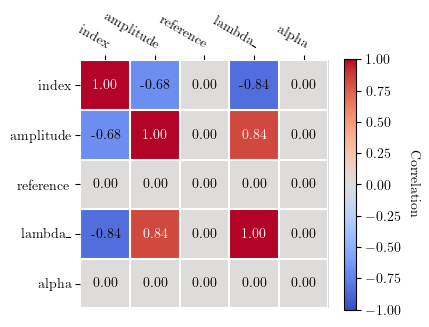

In [23]:
dataset.models[0].spectral_model.covariance.plot_correlation()

<Axes: >

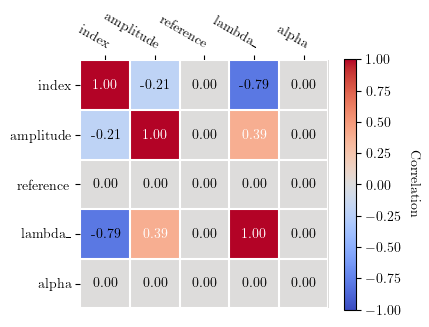

In [24]:
dataset_N.models[0].spectral_model.covariance.plot_correlation()

In [25]:
mask = dataset_input.mask.data.sum(axis=2).sum(axis=1) > 0
ebins =dataset_input.counts.geom.axes[0].edges[:-2]#[2:]#:2]# dataset_input.counts.geom.axes[0].center[mask][::2]
i = 7
asimov, asimov_errors = dataset.models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = dataset_N.models[0].spectral_model.evaluate_error(ebins)
print(dataset.models[0].spectral_model)
print(dataset_N.models[0].spectral_model)

ExpCutoffPowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm link prior
-------- --------- ---------- -------------- --------- --- --- ------ ------- ---- -----
spectral     index 2.3000e+00                9.301e-02 nan nan  False   False       None
spectral amplitude 3.8500e-11 cm-2 s-1 TeV-1 2.606e-12 nan nan  False    True       None
spectral reference 1.0000e+00            TeV 0.000e+00 nan nan   True   False       None
spectral   lambda_ 1.0000e-01          TeV-1 4.003e-02 nan nan  False   False       None
spectral     alpha 1.0000e+00                0.000e+00 nan nan   True   False       None
ExpCutoffPowerLawSpectralModel

  type      name     value         unit        error   min max frozen is_norm link prior
-------- --------- ---------- -------------- --------- --- --- ------ ------- ---- -----
spectral     index 2.3005e+00                1.166e-01 nan nan  False   False       None
spectral amplitude 3.8494e-11 cm-2 s-1 TeV-1 5

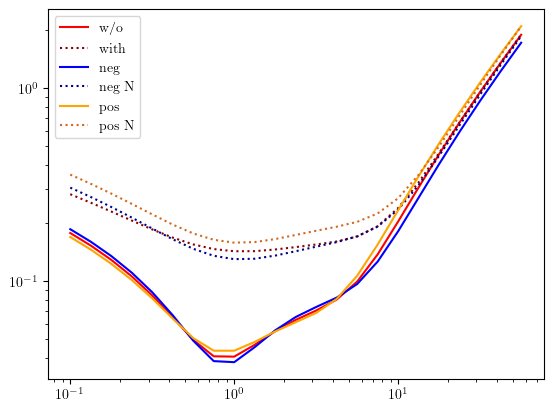

In [26]:

asimov_m, asimov_errors_m =dataset.models[0].spectral_model.evaluate_error(ebins)
plt.plot(ebins ,  asimov_errors_m/asimov_m, color= 'red', linestyle = '-',
        label = "w/o")
asimov_m_N, asimov_errors_m_N =dataset_N.models[0].spectral_model.evaluate_error(ebins)
plt.plot(ebins , asimov_errors_m_N/asimov_m_N, color= 'darkred', linestyle = 'dotted',
        label = "with")
if asym:


    asimov_n, asimov_errors_n =minos_model_n.spectral_model.evaluate_error(ebins)
    plt.plot(ebins ,  asimov_errors_n/asimov_n, color= 'blue', linestyle = '-',
            label = "neg")
    asimov_n_N, asimov_errors_n_N =minos_model_N_n.spectral_model.evaluate_error(ebins)
    plt.plot(ebins , asimov_errors_n_N/asimov_n_N, color= 'darkblue', linestyle = 'dotted',
            label = "neg N")
    plt.xscale('log')

    asimov_p, asimov_errors_p =minos_model_p.spectral_model.evaluate_error(ebins)
    plt.plot(ebins ,  asimov_errors_p/asimov_p, color= 'orange', linestyle = '-',
            label = "pos")
    asimov_p_N, asimov_errors_p_N =minos_model_N_p.spectral_model.evaluate_error(ebins)
    plt.plot(ebins , asimov_errors_p_N/asimov_p_N, color= 'chocolate', linestyle = 'dotted',
            label = "pos N")


plt.xscale('log')

plt.yscale("log")    
plt.legend()

In [27]:


withine_asym = []
withine_N_asym = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux_N:
        value = f[ie]
        lowerlim = np.all(value <= asimov_p.value[ie] + asimov_errors_p.value[ie])
        upperlim = np.all(value >= asimov_n.value[ie] - asimov_errors_n.value[ie])
        x = lowerlim & upperlim
        xs.append(x)

        lowerlim = np.all(value <= asimov_p_N.value[ie] + asimov_errors_p_N.value[ie])
        upperlim = np.all(value >= asimov_n_N.value[ie] - asimov_errors_n_N.value[ie])
        x = lowerlim & upperlim
        xs_N.append(x)

    withine_asym.append(np.count_nonzero(xs) / N)
    withine_N_asym.append(np.count_nonzero(xs_N) / N)
print(withine_asym)
print(withine_N_asym)
print(np.mean(withine_N_asym))

[0.432, 0.411, 0.381, 0.371, 0.335, 0.292, 0.253, 0.249, 0.247, 0.277, 0.286, 0.304, 0.344, 0.372, 0.423, 0.509, 0.595, 0.654, 0.675, 0.707, 0.753, 0.789, 0.75]
[0.701, 0.698, 0.696, 0.694, 0.691, 0.708, 0.705, 0.695, 0.686, 0.676, 0.683, 0.681, 0.682, 0.687, 0.683, 0.681, 0.69, 0.713, 0.71, 0.727, 0.787, 0.789, 0.752]
0.705


[0.432, 0.408, 0.384, 0.373, 0.332, 0.291, 0.252, 0.25, 0.25, 0.276, 0.287, 0.299, 0.338, 0.365, 0.423, 0.502, 0.594, 0.662, 0.695, 0.727, 0.786, 0.765, 0.738]
[0.617, 0.624, 0.632, 0.648, 0.65, 0.677, 0.683, 0.69, 0.696, 0.68, 0.672, 0.658, 0.649, 0.648, 0.643, 0.652, 0.666, 0.695, 0.704, 0.727, 0.786, 0.771, 0.74]
0.678608695652174


Text(0, 0.5, 'Coverage')

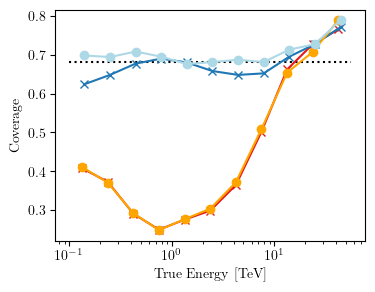

In [28]:


withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux_N:
        value = f[ie]
        lowerlim = np.all(value <= asimov.value[ie] + asimov_errors.value[ie])
        upperlim = np.all(value >= asimov.value[ie] - asimov_errors.value[ie])
        x = lowerlim & upperlim
        xs.append(x)

        lowerlim = np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie])
        upperlim = np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie])
        x = lowerlim & upperlim
        xs_N.append(x)

    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)
print(withine)
print(withine_N)
print(np.mean(withine_N))


#withine = withine_asym
#withine_N = withine_N_asym

fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.plot(ebins, [0.68] * len(ebins), ":", color="black", label="")
    
ax.plot(ebins[1::2], withine[1::2], color=awo[0], marker = 'x',  label="")
ax.plot(ebins[1::2] * 1.05, withine_N[1::2], color=aw[0], marker = 'x', label="")
   
if asym:
    ax.plot(ebins[1::2], withine_asym[1::2], color='orange', marker = 'o',  label="")
    ax.plot(ebins[1::2] * 1.05, withine_N_asym[1::2], color='lightblue', marker = 'o', label="")
    

ax.set_xscale("log")
ax.set_xlabel("True Energy [TeV]")
ax.set_ylabel("Coverage")

2.154434690031884
shift 0.95
shift 1.05


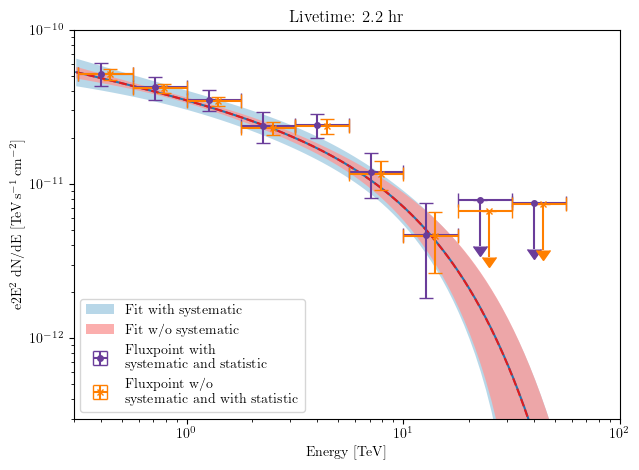

In [29]:
fig, ax = plt.subplots(1,1)
fig = plot_spectrum(i,ax)

2.154434690031884
shift 0.95
shift 1.05


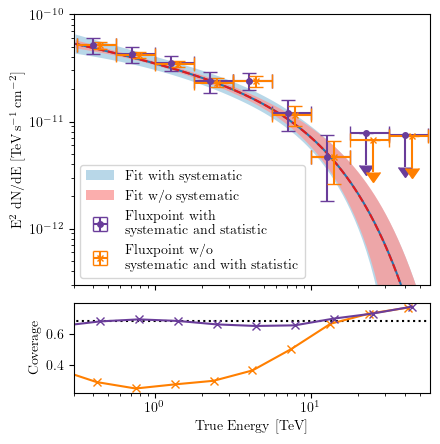

In [30]:
i = 7 
fig, (axs, ax2) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True, figsize=((4.5, 4.5))
)
plot_minuit = 0
fig = plot_spectrum(i, axs)



energy_bounds = (0.3, 100) *u.TeV

#plot_coverage(fig, ax2, withine_asym, withine_N_asym)
plot_coverage(fig, ax2, withine, withine_N)
yy = axs.get_ylim()
#for f in flux2e:
#    axs.plot(ebins, f, color = 'grey', alpha = 0.2)
    
ax2.set_xscale("log")
ax2.set_xlabel("True Energy [TeV]")
#axs.set_ylim(yy[0], yy[1])
#axs.set_ylim(1e-12, yy[1])
#axs.set_ylim(1e-13, yy[1])
axs.set_xlim(0.3, 58)
axs.set_xlabel("")
axs.set_title("")
ax2.set_ylabel("Coverage")
plt.subplots_adjust(wspace=0., hspace=0.1)

axs.set_ylabel('E$^{2}$ dN/dE [$\\mathrm{TeV\\,s^{-1}\\,cm^{-2}}$]')
fig.savefig(f'../{folder}/plots/{nbidx}_spectrum_{livetimes[i]}_{nns[idx]}_{sys}.pdf', bbox_inches = 'tight')
